# Notes and summary 

In this notebook we are extending some functionality from the [original LSTM model ](https://www.kaggle.com/code/slythe/lstm-human-activity-recognition)

We will be using:
* new activation function Bionodal root units - which supposedly are less impacted by vanishing gradients (as opposed to RELU, Sigmoid, TANH etc)
* Quantile Transformation as the scaling method - taken from [DLASTSTARK](https://www.kaggle.com/code/dlaststark/tps-apr22-tfv2)


In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

import tensorflow as tf
from tensorflow.keras import layers, models,callbacks,metrics
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import roc_auc_score, auc

from tensorflow.keras.layers import Bidirectional, Input , BatchNormalization, LSTM, Dense, GlobalMaxPooling1D, Dropout, Concatenate, GRU, Multiply
import gc

In [ ]:
BATCH_SIZE = 256
EPOCHS = 50
FOLDS = 10

DROP_SENSOR= False

SCALING = True
ADD_FEATURES = False

SHIFT_VALS = True

In [ ]:
train_original = pd.read_csv("../input/tabular-playground-series-apr-2022/train.csv")
test = pd.read_csv("../input/tabular-playground-series-apr-2022/test.csv")
train_lables = pd.read_csv("../input/tabular-playground-series-apr-2022/train_labels.csv")
sub= pd.read_csv("../input/tabular-playground-series-apr-2022/sample_submission.csv", index_col = 0)

In [ ]:
sensor_cols = [col for col in train_original.columns if "sensor" in col]

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    BATCH_SIZE = tpu_strategy.num_replicas_in_sync * 64
    print("Running on TPU:", tpu.master())
    print(f"Batch Size: {BATCH_SIZE}")
    
except ValueError:
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = 256
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    print(f"Batch Size: {BATCH_SIZE}")

# Downcasting 

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

reduce_mem_usage(train_original)
reduce_mem_usage(test)

# Shift data

* Groupby sequence & subject  or just sequence 

In [ ]:
def shift_vals(df):
    for col in sensor_cols:
    
        df[f"{col}_shift1"] =df.groupby(["sequence","subject"])[col].shift(1).bfill()
        df[f"{col}_shift2"] =df.groupby(["sequence","subject"])[col].shift(2).bfill()
        df[f"{col}_shift-1"] =df.groupby(["sequence","subject"])[col].shift(-1).ffill()
        #df[f"{col}_shift-2"] =df.groupby(["sequence","subject"])[col].shift(-2).ffill()
        
        df[f"{col}_rolling6"] = df.groupby(["sequence","subject"])[col].shift(1).rolling(6).mean().fillna(0)
        #df[f"{col}_rolling15"] = df.groupby(["sequence","subject"])[col]..shift(1).rolling(15).mean().fillna(0)
        df[f"{col}_rolling10"] = df.groupby(["sequence","subject"])[col].shift(1).rolling(10).mean().fillna(0)
        
        df[col + '_diff1'] = df[col] - df[f"{col}_shift1"]    
        df[col + '_diff-1'] = df[col] - df[f"{col}_shift-1"] 

    return df

if SHIFT_VALS:
    print("shifting values")
    shift_vals(train_original)
    shift_vals(test)

### Drop the sensor data

In [ ]:
if DROP_SENSOR:
    print("dropping raw sensor data")
    train = train.drop(sensor_cols,axis =1)
    test = test.drop(sensor_cols,axis =1)

In [ ]:
gc.collect()

# Additional Features

In [ ]:
def add_features(df):
    new_df = pd.DataFrame()
    df_pivot = df.pivot(index = ["sequence","subject"], columns ="step", values = sensor_cols)
    
    for col in sensor_cols:
#         new_df[f"mean_{col}"] = df_pivot[col].mean(axis = 1)
#         new_df[f"median_{col}"] = df_pivot[col].median(axis = 1)
#         new_df[f"std_{col}"] = df_pivot[col].std(axis = 1)
#         new_df[f"variance_{col}"] = df_pivot[col].std(axis = 1)
#         new_df[f"max_{col}"] = df_pivot[col].max(axis = 1)
#         new_df[f"min_{col}"] = df_pivot[col].min(axis = 1)
#         new_df[f"max-min_{col}"] = df_pivot[col].max(axis = 1) - df.min(axis = 1)
        new_df[f"q01_{col}"] = df_pivot[col].quantile(q= 0.01, axis =1) 
        new_df[f"q50_{col}"] = df_pivot[col].quantile(q= 0.5, axis =1)
        new_df[f"q25_{col}"] = df_pivot[col].quantile(q= 0.25, axis =1) 
        new_df[f"q75_{col}"] = df_pivot[col].quantile(q= 0.75, axis =1)
        new_df[f"q95_{col}"] = df_pivot[col].quantile(q= 0.95, axis =1)
        new_df[f"q99_{col}"] = df_pivot[col].quantile(q= 0.99, axis =1)
        new_df[f"skew_{col}"] = df_pivot[col].skew( axis =1)
        
    df = df.merge(new_df, how = "left", on = "sequence")
    
    return df

if ADD_FEATURES:
    print("Adding Features")
    train = add_features(train_original)
    test = add_features(test)

else :
    train = train_original.copy()

In [ ]:
print([col for col in train.columns])

# Scaling and Reshaping 

**NOTE**: Scaing before splitting causes leakage however Im unsure how to scale after reshaping the data 

We also need to reshape the data for LSTM in the format: 
* samples 
* timesteps 
* features 

i.e. reshape.(samples, timesteps, features) 

In [ ]:
train= train.drop(["sequence","subject"],axis =1).set_index("step")
test= test.drop(["sequence","subject"],axis =1).set_index("step")

In [ ]:
FEATURES = len(train.columns)

In [ ]:
if SCALING:
    print("scaling")
#     scaler= StandardScaler()
#     train = scaler.fit_transform(train)
#     test = scaler.transform(test)
    
    scaler = QuantileTransformer(n_quantiles=2000, 
                                 output_distribution='normal', 
                                 random_state=42).fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)

In [ ]:
train = train.reshape( int(len(train)/60), 60, FEATURES)
test = test.reshape( int(len(test)/60), 60, FEATURES)

# Split 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train, train_lables["state"], test_size=0.33, shuffle = False)

# Build and Train


## Bionodal Root Unit (BRU)- activation function
We will be implementing  this activation function as it is supposedly less impacted by vanishing gradients as opposed to RELU (when values tend towards 0) \
BRU was first mentioned in this [paper](https://arxiv.org/pdf/1804.11237.pdf) and was seen to improve model accuracy against relu and elu activation functions 


Activaton function code taken from [James Brown](https://www.kaggle.com/code/bluebuddha/bionodal-root-units-experiment#Fit-Comparison-Models-On-MNIST-Image-Set)

**We have two types of BRU activation functions ERU and ORO**

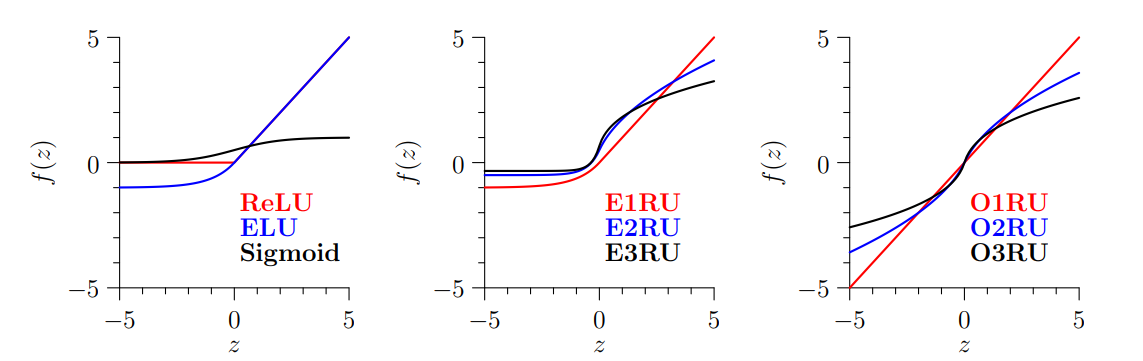

In [ ]:
def make_bru_eru(r=1.0):
  def bru_eru(z):
    return tf.where(tf.greater_equal(z, 0.0),
                    tf.subtract(tf.pow(tf.add(
                        tf.multiply(r**2,
                                    tf.where(z < 0.0, tf.constant(0.0), z)
                                    ), 1.0), 1.0/r), 1.0/r),
                    tf.subtract(tf.exp(
                        tf.multiply(r, 
                                    tf.where(z < 0.0, z, tf.constant(-1.0))
                                    )), 1.0/r))
  return bru_eru

In [ ]:
def make_bru_oru(r=1.0):
  @tf.custom_gradient
  def bru_oru(z):
    def grad(dy):
      return tf.multiply(dy, tf.multiply(r, tf.pow(tf.add(
          tf.multiply(r**2, tf.abs(z)), 1.0), (1-r)/r)))
    return tf.multiply(tf.sign(z), tf.subtract(tf.pow(tf.add(
        tf.multiply(r**2, tf.abs(z)), 1.0), 1.0/r), 1.0)), grad
  return bru_oru

Model was adapted from [davidedwards1](https://www.kaggle.com/code/davidedwards1/tps-april-tensorflow-bi-lstm-10f-spatialdropout#Feature-Engineering) 

In [ ]:
def build_model():   
    with tpu_strategy.scope():
    
        input_layer = layers.Input(shape=(train.shape[-2:]))
        b = layers.BatchNormalization()(input_layer)
        x0 = layers.SpatialDropout1D(rate=0.4)(b)
        x1 = layers.Bidirectional(layers.LSTM(768, return_sequences=True))(x0)
        x2 = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(x1)
        x3 = layers.Bidirectional(layers.LSTM(384, return_sequences=True))(x2)
        x4 = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x3)
        x5 = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x4)
        x6 = layers.Concatenate(axis=2)([x1,x2, x3, x4,x5])
        x7 = layers.GlobalMaxPooling1D()(x6) 
        x8 = layers.Dense(128, activation= make_bru_oru(2.0))(x7)
        x9 = layers.Dropout(0.2)(x8)
        output_layer = layers.Dense(units=1, activation="sigmoid")(x8)
        model = models.Model(inputs=input_layer, outputs=output_layer, name='DNN_Model')
        
        model.compile(optimizer="adam",loss="binary_crossentropy", metrics=[metrics.AUC(name = 'auc')])
        
    return(model)

model = build_model()

In [ ]:
model.summary()

In [ ]:
with tpu_strategy.scope():
    model = build_model()
    model.fit(X_train ,
              y_train,
              epochs= EPOCHS, 
              callbacks= [callbacks.EarlyStopping(monitor='val_auc',mode='max', patience=10, verbose=1,restore_best_weights=True),
                          callbacks.ReduceLROnPlateau(monitor="val_auc",mode='max', factor=0.7, patience=1, verbose=1)],
              validation_data=(X_test,
                               y_test), 
              batch_size = BATCH_SIZE
             )

In [ ]:
history = pd.DataFrame(model.history.history)
history

In [ ]:
val_preds = model.predict(X_test, batch_size = BATCH_SIZE)
train_preds = model.predict(X_train, batch_size = BATCH_SIZE)
train_preds

In [ ]:
print("Validation AUC:" , roc_auc_score(y_test, val_preds ))
print("Intrinsic AUC:", roc_auc_score(y_train, train_preds ))

In [ ]:
history[["loss","val_loss"]].plot(figsize = (20,8))
plt.title("Training vs Validation Loss")
plt.show()

In [ ]:
history[["auc","val_auc"]].plot(figsize = (20,8))
plt.title("Training vs Validation AUC")
plt.show()

# Cross Validation

In [ ]:
del model
del X_train
del y_train
del X_test
del y_test
del val_preds
del train_preds
del history

gc.collect()

In [ ]:
X = train
y = train_lables["state"]

In [ ]:
kfold = GroupKFold(n_splits = FOLDS)

In [ ]:
auc_cv = []
preds = []

for fold, (train_idx, val_idx) in enumerate (kfold.split(X,y, groups =train_original.sequence.unique())):

    print("\n","#"*10, f"Fold {fold+1}","#"*10)
    X_train, X_test = X[train_idx] , X[val_idx]
    y_train , y_test = y[train_idx], y[val_idx]
    
    with tpu_strategy.scope():
        model = build_model()

        model.compile(optimizer="adam", loss="binary_crossentropy", metrics="AUC")
        model.fit(X_train,y_train,epochs= EPOCHS, 
                  callbacks= [callbacks.EarlyStopping(patience=10,monitor='val_auc', mode = "max") ,
                              callbacks.ReduceLROnPlateau(monitor="val_auc",mode = "max",patience = 10, factor= 0.1 ,restore_best_weights=True)],
                  validation_data=(X_test,y_test), batch_size = BATCH_SIZE)

        auc = roc_auc_score(y_test, model.predict(X_test,batch_size = BATCH_SIZE))
        print("\n Validation AUC:" , auc)

        auc_cv.append(auc)
        preds.append(model.predict(test,batch_size = BATCH_SIZE).squeeze())
    
    del X_train
    del X_test
    del y_train
    del y_test
    del model
    
    gc.collect()

print("FINAL AUC: ", np.mean(auc_cv))

# Submission

In [ ]:
final_preds = np.sum(preds,axis =0)/FOLDS
sub["state"] = final_preds
sub.to_csv("submission.csv")
sub

In [ ]:
plt.figure(figsize = (20,8))
sns.histplot(sub["state"])
plt.show()